## Task 2 - Code Comprehension  

Original Notebook from [Kaggle](https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish)  

The task in this Notebook is to fill in missing pieces of code (nothing complicated) and correct errors. The task is done when the cell at the bottom of the notebook verifies that the problems were fixed.  

<div style="display: none" id="notebookName">task_2</div>

# Machine Learning from Start to Finish with Scikit-Learn

This notebook covers the basic Machine Learning process in Python step-by-step. Go from raw data to at least 78% accuracy on the Titanic Survivors dataset. 

### Steps Covered


1. Importing  a DataFrame
2. Visualize the Data
3. Cleanup and Transform the Data
4. Encode the Data
5. Split Training and Test Sets
6. Fine Tune Algorithms
7. Cross Validate with KFold
8. Upload to Kaggle

## CSV to DataFrame

CSV files can be loaded into a dataframe by calling `pd.read_csv` . After loading the training and test files, print a `sample` to see what you're working with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_train = pd.read_csv('./data/titanic/train.csv') #1
data_test = pd.read_csv('./data/titanic/test.csv')

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
844,845,0,3,"Culumovic, Mr. Jeso",male,17.0,0,0,315090,8.6625,NaN,S
373,374,0,1,"Ringhini, Mr. Sante",male,22.0,0,0,PC 17760,135.6333,NaN,C
262,263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.6500,E67,S


## Visualizing Data

Visualizing data is crucial for recognizing underlying patterns to exploit in the model. 

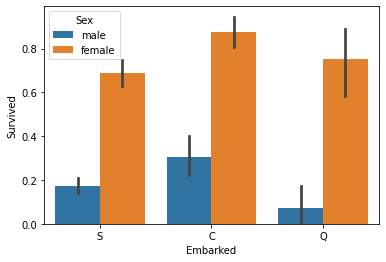

In [2]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

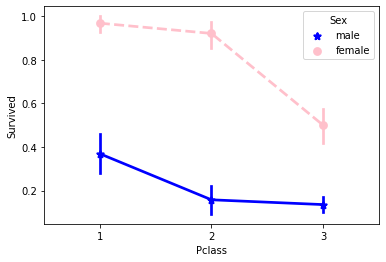

In [3]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train, #2
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

## Transforming Features

1. Aside from 'Sex', the 'Age' feature is second in importance. To avoid overfitting, I'm grouping people into logical human age groups. 
2. Each Cabin starts with a letter. I bet this letter is much more important than the number that follows, let's slice it off. 
3. Fare is another continuous value that should be simplified. I ran `data_train.Fare.describe()` to get the distribution of the feature, then placed them into quartile bins accordingly. 
4. Extract information from the 'Name' feature. Rather than use the full name, I extracted the last name and name prefix (Mr. Mrs. Etc.), then appended them as their own features. 
5. Lastly, drop useless features. (Ticket and Name)

In [4]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior'] #3
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df) #4
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


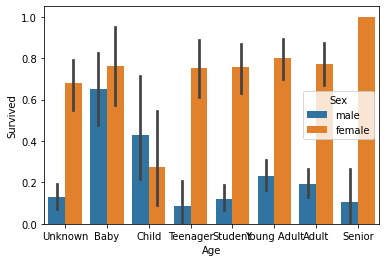

In [5]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

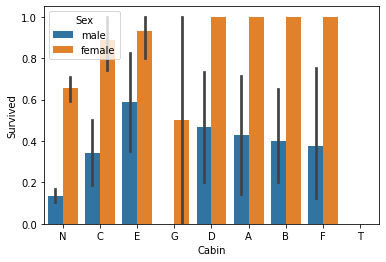

In [6]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

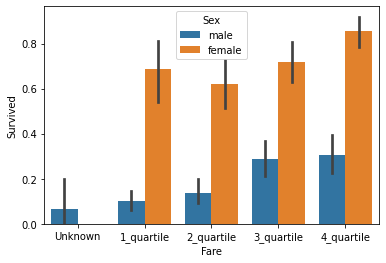

In [7]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

## Some Final Encoding

The last part of the preprocessing phase is to normalize labels. The LabelEncoder in Scikit-learn will convert each unique string value into a number, making out data more flexible for various algorithms. 

The result is a table of numbers that looks scary to humans, but beautiful to machines. 

In [8]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


## Splitting up the Training Data

Now its time for some Machine Learning. 

First, separate the features(X) from the labels(y). 

**X_all:** All features minus the value we want to predict (Survived).

**y_all:** Only the value we want to predict. 

Second, use Scikit-learn to randomly shuffle this data into four variables. In this case, I'm training 80% of the data, then testing against the other 20%.  

Later, this data will be reorganized into a KFold pattern to validate the effectiveness of a trained algorithm. 

In [9]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

## Fitting and Tuning an Algorithm

Now it's time to figure out which algorithm is going to deliver the best model. I'm going with the RandomForestClassifier, but you can drop any other classifier here, such as Support Vector Machines or Naive Bayes. 

In [10]:
# This cell builds the model, which will take a few seconds.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_split=5, n_estimators=9)

In [11]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8379888268156425


## Validate with KFold

Is this model actually any good? It helps to verify the effectiveness of the algorithm using KFold. This will split our data into 10 buckets, then run the algorithm using a different bucket as the test set for each iteration. 

In [12]:
from sklearn.model_selection import KFold

def run_kfold(clf):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.8111111111111111
Fold 2 accuracy: 0.898876404494382
Fold 3 accuracy: 0.797752808988764
Fold 4 accuracy: 0.8314606741573034
Fold 5 accuracy: 0.8651685393258427
Fold 6 accuracy: 0.797752808988764
Fold 7 accuracy: 0.7752808988764045
Fold 8 accuracy: 0.8089887640449438
Fold 9 accuracy: 0.8539325842696629
Fold 10 accuracy: 0.8426966292134831
Mean Accuracy: 0.8283021223470662


## Predict the Actual Test Data

And now for the moment of truth. Make the predictions, export the CSV file, and upload them to Kaggle.

In [13]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('./data/titanic/titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


# Correctness Checking

In [20]:
if accuracy_score(y_test, clf.predict(X_test)) > 0.78:
    print("> Model accuracy OK")
    print("> Notebook flaws corrected!")
else:
    print("> Model too inaccurate, check for flaws and re-run notebook")

> Model accuracy OK
> Notebook flaws corrected!


Here is a reminder to "submit" your notebook using the <i class="fa fa-upload"></i> button above.

**Thank you very much** for participating!  